# BBC News Classification Project

For this week’s mini-project, you will participate in this Kaggle competition: (https://www.kaggle.com/c/learn-ai-bbc/overview) 

Github: https://github.com/GHeart01/BCC_News_Classification

This Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category and submit your notebook for peer evaluation. 
The Jupyter notebook should show a brief EDA procedure, model building and training, results, and comparison with supervised learning. 

### Table of Contents

- [Description](#Description)
- [EDA](#Exploratory-Data-Analysis-(EDA)-Procedure)
- [Model Building and Training](#Model-Building-and-Training)
- [Comparision with Supervised Machine Learning](#Comparision-with-Supervised-Machine-Learning)
- [Data Efficency Analysis](#Data-Efficency-Analysis)
- [Citation](#Citation)

### Description

Text documents are one of the richest sources of data for businesses.

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

The evaluation metric for this competition is Accuracy. Sample Solution FIle shows the format required for submission. The file should contain a header and have the following two columns ArticleId (from Test File) Category (one of the five categories - sport, tech, business, entertainment or politics)

### Exploratory Data Analysis (EDA) Procedure

In [140]:
#import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import itertools
import warnings
warnings.filterwarnings('ignore')

#### Load The Data

In [141]:
data_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
data_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
BBC_Solution = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

print(f"Training data shape: {data_train.shape}")
print(f"Test data shape: {data_test.shape}")
print(f"Sample solution shape: {BBC_Solution.shape}")

print("\nTRAINING DATA")
print(data_train.head())
print(data_train.tail())

print("\nDATA INFO")
print("Training data info:")
print(data_train.info())

Training data shape: (1490, 3)
Test data shape: (735, 2)
Sample solution shape: (735, 2)

TRAINING DATA
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
      ArticleId                                               Text  \
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
1485  ent

Next I'm going to check for missing and duplicated values

In [142]:
print(f"Missing values in training data:\n{data_train.isnull().sum()}")
print(f"Missing values in test data:\n{data_test.isnull().sum()}")

# Check for duplicate articles
print(f"\nDuplicate ArticleIds in training: {data_train['ArticleId'].duplicated().sum()}")
print(f"Unique ArticleIds in training: {data_train['ArticleId'].nunique()}")

# Check for duplicate texts
duplicate_texts = data_train.duplicated(subset="Text", keep=False).sum()
print(f"Duplicate texts in training: {duplicate_texts}")

# Check texts appearing in multiple categories
duplicates_across_categories = data_train.groupby("Text")["Category"].nunique()
multi_category_texts = (duplicates_across_categories > 1).sum()
print(f"Texts appearing in multiple categories: {multi_category_texts}")

Missing values in training data:
ArticleId    0
Text         0
Category     0
dtype: int64
Missing values in test data:
ArticleId    0
Text         0
dtype: int64

Duplicate ArticleIds in training: 0
Unique ArticleIds in training: 1490
Duplicate texts in training: 100
Texts appearing in multiple categories: 0


Output here is 1490 which from the head and tail EDA and the Kaggle problem given information tells us there are no duplicate rows, we could have articles that contain multiple categories. This is a part of the data cleaning we will perform later.

#### Visualization

Here I am going to build a histogram to gain a visual on the Kaggle data. I am also going to apply a mean, min, and max histogram analysis.

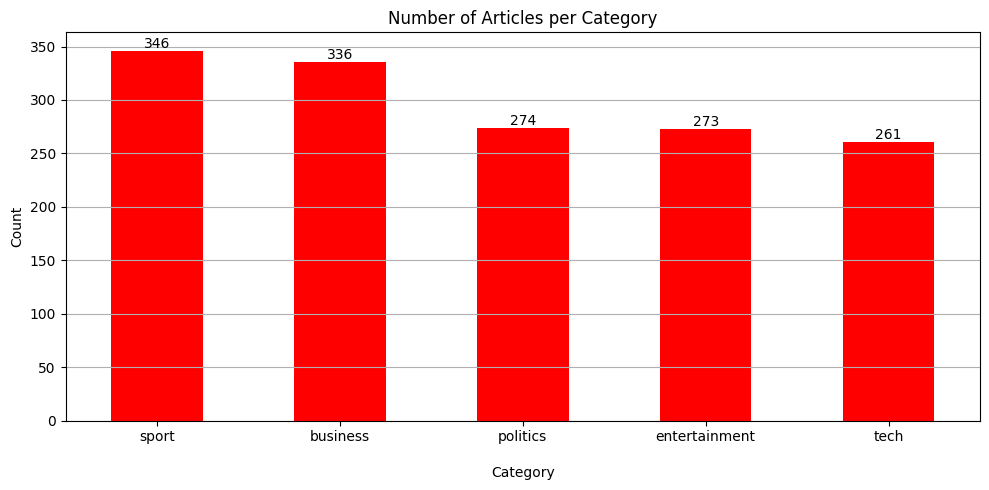

In [143]:
import matplotlib.pyplot as plt

# plot
ax = data_train['Category'].value_counts().plot(kind='bar', figsize=(10, 5), color='red')
plt.title("Number of Articles per Category")
plt.xlabel("\nCategory")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')

# Add values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

Between our 5 unique catagories [sport, business, politics, entertainment, tech] we see somewhat even distribution. The mean articles per catagory, 1490/5 is 298. Thus from a quick standard deviation estimate:

$$
σ = \sqrt{\frac{1}{5} \sum_{i=1}^{5} (x_i - \bar{x})^2}
$$ 
= 
$$
\sqrt{\frac{1}{5} \sum_{i=1}^{5} (x_i - 298)^2}= 35.8
$$ 


There is a moderate spread in our data.

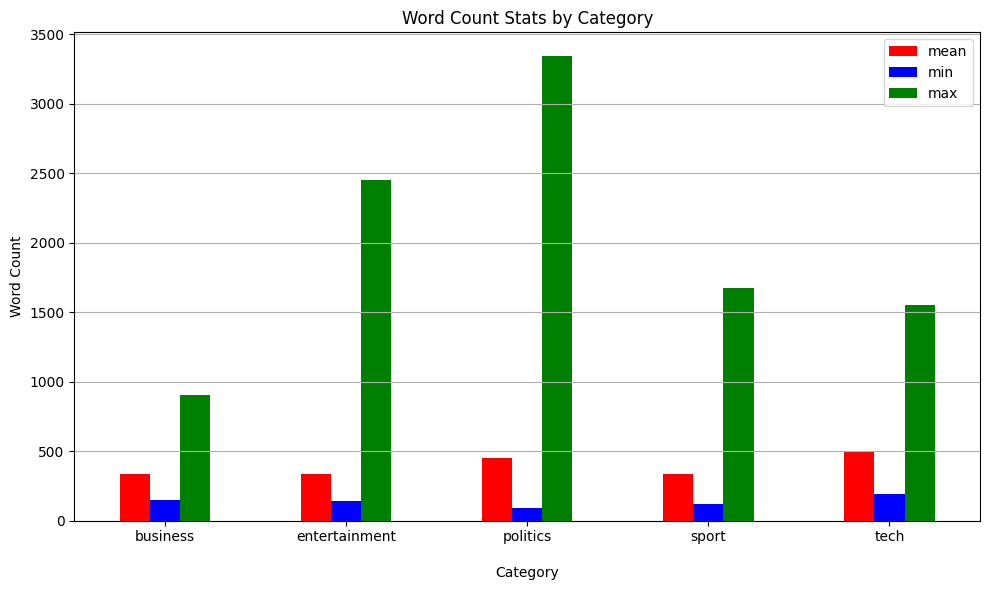

In [144]:
data_train["word_count"] = data_train["Text"].apply(lambda x: len(str(x).split()))

stats_train = data_train.groupby('Category')['word_count'].agg(['mean', 'min', 'max'])

stats_train.plot(kind='bar', figsize=(10, 6), color = {"red","blue","green"})
plt.title("Word Count Stats by Category")
plt.ylabel("Word Count")
plt.xlabel("\nCategory")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

From this histogram there is a huge range in the min and max word count of articles in each catagory. 
#### Removing Duplicates (Data Cleaning)
There may be articles that contain more than more catagory. Thus Ill run a check, and remove any duplicats.

In [145]:
data_train_clean = data_train.drop_duplicates(subset="Text", keep='first')
print(f"After removing duplicate texts: {data_train_clean.shape}")

# Update data_train
data_train = data_train_clean.copy()

After removing duplicate texts: (1440, 4)


### Model Building and Training

Now that the data has been prepped I will build the model. This model, based on the assignment for this class, is to be built using sklearn's Non-Negative Matrix Factorization method. I will use the sklearn.deocmpositionNMF class found here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

There are many methods process texts to matrix form (word embedding), including **TF-IDF**, GloVe, Word2Vec, etc. Here I will use TF-IDF.


In [146]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,        # Ignore terms that appear in >95% of documents
    min_df=2,           # Ignore terms that appear in <2 documents
    stop_words='english',
    # max_features=5000   
)

# Fit on training data only
X_train_tfidf = tfidf_vectorizer.fit_transform(data_train['Text'])
print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Number of features (unique words): {len(tfidf_vectorizer.get_feature_names_out())}")

# Show most important features
feature_names = tfidf_vectorizer.get_feature_names_out()
mean_tfidf = np.array(X_train_tfidf.mean(axis=0)).flatten()
top_features = np.argsort(mean_tfidf)[-20:]
print(f"\nTop 20 words by average TF-IDF score:")
for i, idx in enumerate(reversed(top_features)):
    print(f"{i+1:2d}. {feature_names[idx]:15s} ({mean_tfidf[idx]:.4f})")


TF-IDF matrix shape: (1440, 13752)
Number of features (unique words): 13752

Top 20 words by average TF-IDF score:
 1. said            (0.0404)
 2. mr              (0.0265)
 3. year            (0.0192)
 4. people          (0.0168)
 5. new             (0.0167)
 6. film            (0.0151)
 7. government      (0.0133)
 8. world           (0.0131)
 9. uk              (0.0129)
10. best            (0.0125)
11. time            (0.0124)
12. labour          (0.0120)
13. game            (0.0117)
14. election        (0.0110)
15. england         (0.0105)
16. blair           (0.0103)
17. years           (0.0103)
18. music           (0.0099)
19. 000             (0.0099)
20. number          (0.0098)


In [147]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(data_train['Category'])

for i, category in enumerate(label_encoder.classes_):
    category_mask = y_train_encoded == i
    category_tfidf = X_train_tfidf[category_mask].mean(axis=0)
    category_tfidf_array = np.array(category_tfidf).flatten()
    top_indices = np.argsort(category_tfidf_array)[-10:]

Here we can see keywords that are shared between articles.

In [148]:
# Combine train and test texts for TF-IDF fitting (unsupervised approach)
all_texts = pd.concat([data_train['Text'], data_test['Text']], ignore_index=True)
print(f"Combined corpus size: {len(all_texts)} documents")

# Refit TF-IDF on combined corpus
tfidf_combined = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words='english',
    # max_features=5000
)

X_combined = tfidf_combined.fit_transform(all_texts)
X_train_combined = X_combined[:len(data_train)]
X_test_combined = X_combined[len(data_train):]

print(f"Combined TF-IDF matrix shape: {X_combined.shape}")
print(f"Train subset shape: {X_train_combined.shape}")
print(f"Test subset shape: {X_test_combined.shape}")

Combined corpus size: 2175 documents
Combined TF-IDF matrix shape: (2175, 17243)
Train subset shape: (1440, 17243)
Test subset shape: (735, 17243)


Lets take a look at a Confusion Matrix for the Data

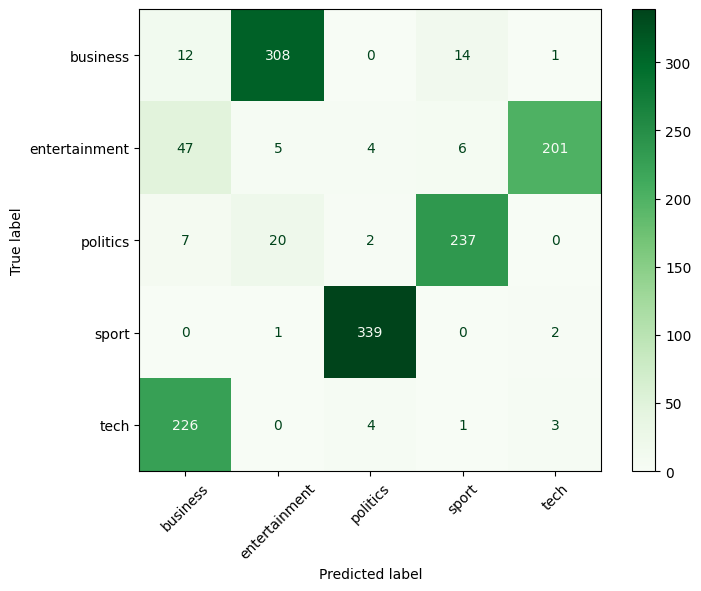

In [149]:
label_encoder = LabelEncoder()
y_true_train = label_encoder.fit_transform(data_train['Category'].values.ravel())

mapped_preds = [perm[label] for label in y_pred_train_as_int]

cm = confusion_matrix(y_true_train, mapped_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Greens", ax=ax)
plt.show()

Here we can see tech-entertainment and business-politics have higher levels of confusion than most other catagories. Between business and politics the misclassificiation may come from articles like finacial policy or political economy. This is purly speculative, but as the matrix appears to show a high level of certainty in dermination of News label classification it is fair to assume the NMF model performed well. 

Here we can see the accuracy before hypertuning

In [150]:
baseline_model = NMF(n_components=5, init='random', max_iter=200, random_state=42)
W_baseline = baseline_model.fit_transform(X_combined)
W_train_baseline = W_baseline[:len(data_train)]
y_pred_baseline = W_train_baseline.argmax(axis=1)

# Get baseline accuracy using label_permute_compare
baseline_perm, baseline_acc = label_permute_compare(data_train[['Category']], y_pred_baseline, n_components=5)

print(f"Baseline Training Accuracy: {baseline_acc:.4f}")
print(f"Baseline Permutation Mapping: {baseline_perm}")

Baseline Training Accuracy: 0.8965
Baseline Permutation Mapping: (2, 3, 1, 4, 0)


#### Hyperparameter Testing
Here I am going to briefly try to improve accuracy agasint the test data. 

In [151]:
best_n_comp = 5
print(f"Best n_components: {best_n_comp}")

# Step 2: Test other parameters with best n_components
print(f"\nStep 2: Optimizing other parameters with n_components={best_n_comp}...")
refined_params = [
    {'init': 'random', 'max_iter': 200},
    {'init': 'nndsvd', 'max_iter': 200},
    {'init': 'random', 'max_iter': 300},
]

results = []
best_accuracy = 0
best_params = None
best_model = None
best_perm = None

print("init    | max_iter | Train Acc")
print("-" * 30)

for params in refined_params:
    try:
        nmf_model = NMF(
            n_components=best_n_comp,
            init=params['init'],
            max_iter=params['max_iter'],
            random_state=42
        )
        
        W_combined = nmf_model.fit_transform(X_combined)
        W_train = W_combined[:len(data_train)]
        y_pred_train = W_train.argmax(axis=1)
        perm, acc = label_permute_compare(data_train[['Category']], y_pred_train, best_n_comp)
        
        full_params = {**params, 'n_components': best_n_comp}
        results.append({
            'params': full_params,
            'accuracy': acc,
            'permutation': perm,
            'model': nmf_model
        })
        
        print(f"{params['init']:7s} | {params['max_iter']:8d} | {acc:.4f}")
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = full_params
            best_model = nmf_model
            best_perm = perm
            
    except Exception as e:
        print(f"Error with params {params}: {e}")


print(f"\nBest Parameters: {best_params}")
print(f"Best Training Accuracy: {best_accuracy:.4f}")

Best n_components: 5

Step 2: Optimizing other parameters with n_components=5...
init    | max_iter | Train Acc
------------------------------
random  |      200 | 0.8965
nndsvd  |      200 | 0.9160
random  |      300 | 0.8965

Best Parameters: {'init': 'nndsvd', 'max_iter': 200, 'n_components': 5}
Best Training Accuracy: 0.9160


With some hyperparameter tuning I achieved accuracy of 91.61%, and improvement over the 89.65% accuracy before hypertuning

#### Best Model (Hypertuned)

hypertuned model
Final Training Accuracy: 0.9160


<Figure size 1000x800 with 0 Axes>

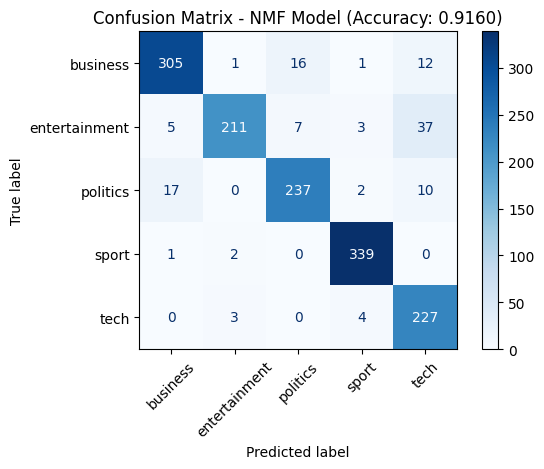

In [152]:
# Retrain best model for detailed analysis
print("hypertuned model")
final_model = NMF(**best_params, random_state=42)
W_final = final_model.fit_transform(X_combined)
H_final = final_model.components_

# Split results
W_train_final = W_final[:len(data_train)]
W_test_final = W_final[len(data_train):]

# Predictions
y_pred_train_final = W_train_final.argmax(axis=1)
y_pred_test_final = W_test_final.argmax(axis=1)

# Apply best permutation
mapped_train_preds = [best_perm[label] for label in y_pred_train_final]
mapped_test_preds = [best_perm[label] for label in y_pred_test_final]

# Training accuracy
y_true_train_encoded = label_encoder.fit_transform(data_train['Category'])
train_accuracy = accuracy_score(y_true_train_encoded, mapped_train_preds)
print(f"Final Training Accuracy: {train_accuracy:.4f}")

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_train_encoded, mapped_train_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix - NMF Model (Accuracy: {train_accuracy:.4f})")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

Classification

In [153]:
print("\nClassification Report:")
print(classification_report(y_true_train_encoded, mapped_train_preds, 
                          target_names=label_encoder.classes_))




Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.91      0.92       335
entertainment       0.97      0.80      0.88       263
     politics       0.91      0.89      0.90       266
        sport       0.97      0.99      0.98       342
         tech       0.79      0.97      0.87       234

     accuracy                           0.92      1440
    macro avg       0.92      0.91      0.91      1440
 weighted avg       0.92      0.92      0.92      1440



This is just a reiteration of the accuracy data I presented in the previous blocks

In [154]:
### 4.3 Topic Analysis

print("\n=== DISCOVERED TOPICS ANALYSIS ===")
feature_names_combined = tfidf_combined.get_feature_names_out()

print("Top words for each discovered topic:")
for topic_idx in range(best_params['n_components']):
    top_words_idx = H_final[topic_idx].argsort()[-15:][::-1]
    top_words = [feature_names_combined[i] for i in top_words_idx]
    top_scores = [H_final[topic_idx][i] for i in top_words_idx]
    
    print(f"\nTopic {topic_idx}:")
    for word, score in zip(top_words, top_scores):
        print(f"  {word:15s} ({score:.4f})")


=== DISCOVERED TOPICS ANALYSIS ===
Top words for each discovered topic:

Topic 0:
  england         (0.5842)
  game            (0.5155)
  win             (0.3721)
  wales           (0.3642)
  ireland         (0.3426)
  cup             (0.3298)
  said            (0.3189)
  team            (0.3124)
  play            (0.3046)
  players         (0.3022)
  rugby           (0.2979)
  match           (0.2960)
  injury          (0.2773)
  france          (0.2769)
  coach           (0.2745)

Topic 1:
  mr              (0.7875)
  labour          (0.6188)
  election        (0.5319)
  blair           (0.5286)
  brown           (0.4422)
  party           (0.4115)
  said            (0.3763)
  government      (0.3010)
  howard          (0.2953)
  minister        (0.2740)
  tax             (0.2666)
  chancellor      (0.2661)
  prime           (0.2638)
  tory            (0.2397)
  tories          (0.2170)

Topic 2:
  growth          (0.4063)
  economy         (0.3818)
  said            (0.3415)
  bank

#### Test Predictions
This is for the Kaggle accuracy comparision

In [155]:
predicted_labels_test = label_encoder.classes_[mapped_test_preds]

print(f"\nTest predictions sample:")
for i in range(10):
    print(f"Article {i+1}: {predicted_labels_test[i]}")

# Create submission file
submission = pd.DataFrame({
    'ArticleId': data_test['ArticleId'],
    'Category': predicted_labels_test
})

print(f"\nSubmission file preview:")
print(submission.head(10))

# Save submission
submission.to_csv('nmf_submission.csv', index=False)
print("Submission saved as 'nmf_submission.csv'")


Test predictions sample:
Article 1: sport
Article 2: tech
Article 3: sport
Article 4: business
Article 5: sport
Article 6: sport
Article 7: politics
Article 8: politics
Article 9: entertainment
Article 10: business

Submission file preview:
   ArticleId       Category
0       1018          sport
1       1319           tech
2       1138          sport
3        459       business
4       1020          sport
5         51          sport
6       2025       politics
7       1479       politics
8         27  entertainment
9        397       business
Submission saved as 'nmf_submission.csv'


### Comparision with Supervised Machine Learning

In [156]:
# prevent data contamination
X_train_supervised = tfidf_combined.transform(data_train['Text'])
X_test_supervised = tfidf_combined.transform(data_test['Text'])
y_train_supervised = data_train['Category']

# Here I am going to test both LR and RF

supervised_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

supervised_results = {}

for name, model in supervised_models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_supervised, y_train_supervised)
    
    # Predictions
    train_pred = model.predict(X_train_supervised)
    test_pred = model.predict(X_test_supervised)
    
    # Accuracy
    train_acc = accuracy_score(y_train_supervised, train_pred)
    
    supervised_results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'train_predictions': train_pred,
        'test_predictions': test_pred
    }
    
    print(f"{name} Training Accuracy: {train_acc:.4f}")



Training Logistic Regression...
Logistic Regression Training Accuracy: 0.9972

Training Random Forest...
Random Forest Training Accuracy: 1.0000


The supervised machine learning models both achieved extremely high performance. Next I take a look at data efficiency.

### Data Efficency Analysis


=== DATA EFFICIENCY ANALYSIS ===
Comparing model performance with different amounts of training data...

Using 10% of training data (144 samples):
  Logistic Regression: 0.6562
  Random Forest: 0.7861

Using 20% of training data (288 samples):
  Logistic Regression: 0.8972
  Random Forest: 0.9153

Using 30% of training data (432 samples):
  Logistic Regression: 0.9528
  Random Forest: 0.9542

Using 50% of training data (720 samples):
  Logistic Regression: 0.9792
  Random Forest: 0.9715

Using 70% of training data (1007 samples):
  Logistic Regression: 0.9847
  Random Forest: 0.9840

Using 100% of training data (1440 samples):
  Logistic Regression: 0.9972
  Random Forest: 1.0000
  NMF (unsupervised): 0.9160


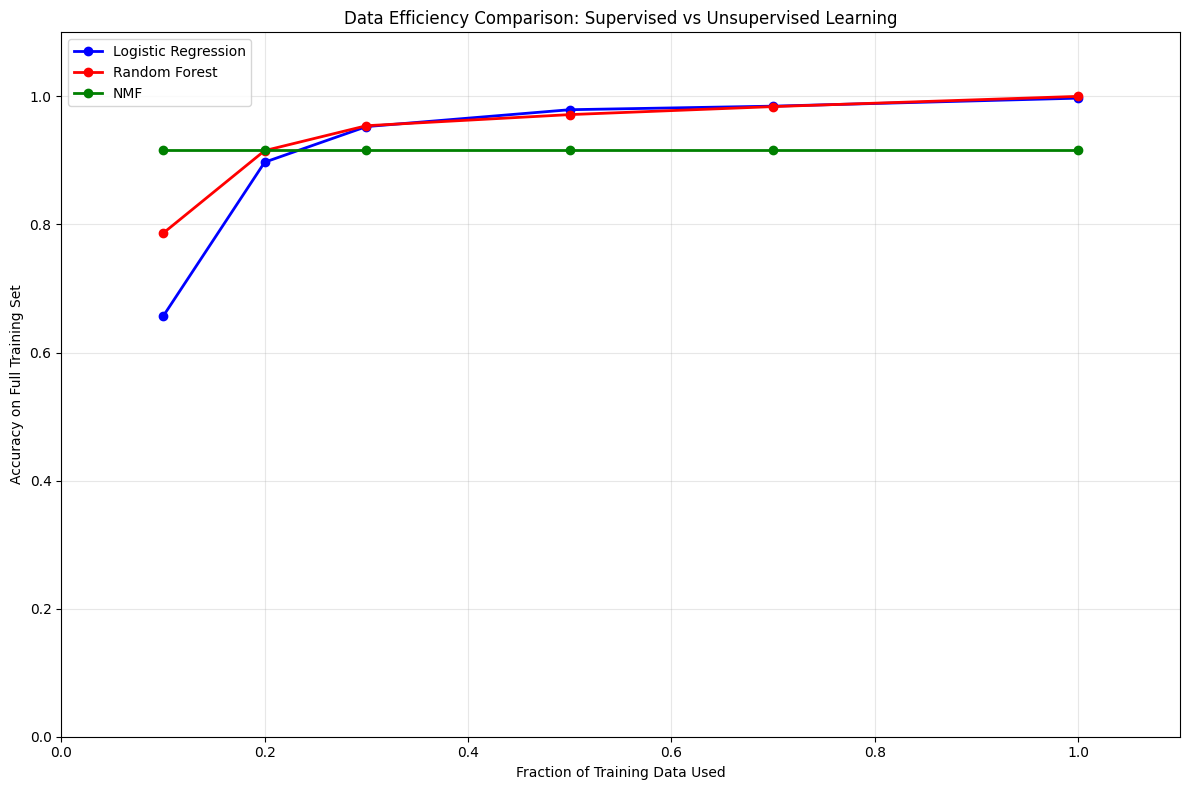

NMF (Unsupervised)   0.9160            
Logistic Regression  0.9972             
Random Forest        1.0000             


In [157]:
print("\n=== DATA EFFICIENCY ANALYSIS ===")
print("Comparing model performance with different amounts of training data...")

data_fractions = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
efficiency_results = {model_name: {'fractions': [], 'accuracies': []} 
                     for model_name in supervised_models.keys()}
efficiency_results['NMF'] = {'fractions': [], 'accuracies': []}

for fraction in data_fractions:
    n_samples = int(len(data_train) * fraction)
    
    # Sample data
    train_sample = data_train.sample(n=n_samples, random_state=42)
    X_sample = tfidf_combined.transform(train_sample['Text'])
    y_sample = train_sample['Category']
    
    print(f"\nUsing {fraction*100:.0f}% of training data ({n_samples} samples):")
    
    # Test supervised models
    for name, model_info in supervised_models.items():
        model = model_info.__class__(**model_info.get_params()) if hasattr(model_info, 'get_params') else model_info
        
        model.fit(X_sample, y_sample)
        sample_pred = model.predict(X_train_supervised)
        sample_acc = accuracy_score(y_train_supervised, sample_pred)
        
        efficiency_results[name]['fractions'].append(fraction)
        efficiency_results[name]['accuracies'].append(sample_acc)
        
        print(f"  {name}: {sample_acc:.4f}")
    
    # Test NMF (unsupervised - doesn't change with label amount)
    if fraction == 1.0:  # Only calculate once since it's unsupervised
        nmf_acc = train_accuracy
        for frac in data_fractions:
            efficiency_results['NMF']['fractions'].append(frac)
            efficiency_results['NMF']['accuracies'].append(nmf_acc)
        print(f"  NMF (unsupervised): {nmf_acc:.4f}")

#plot Visualization

plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange']
for i, (name, results) in enumerate(efficiency_results.items()):
    plt.plot(results['fractions'], results['accuracies'], 
             marker='o', label=name, color=colors[i % len(colors)], linewidth=2)

plt.xlabel('Fraction of Training Data Used')
plt.ylabel('Accuracy on Full Training Set')
plt.title('Data Efficiency Comparison: Supervised vs Unsupervised Learning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)


plt.tight_layout()
plt.show()

### 5.4 Comprehensive Results Summary

print(f"{'NMF (Unsupervised)':<20} {train_accuracy:<18.4f}")

for name, results in supervised_results.items():
    print(f"{name:<20} {results['train_accuracy']:<18.4f} ")

Here we see a massive performance from the supervised machine learning models, with the caveat being their requirement for labels, while the matrix factorization method does no require labels. In addition, for small fractions of training data used, NMF performed much better, more interestingly NMF did not appear to perform any better with more training data samples.

### Citation
1. Lee, D. D., & Seung, H. S. (1999). Learning the parts of objects by non-negative matrix factorization. Nature, 401(6755), 788-791.

2. Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.

3. Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), 2825-2830.

4. Manning, C. D., Raghavan, P., & Schütze, H. (2008). Introduction to information retrieval. Cambridge University Press.

5. Kaggle BBC News Classification Competition: https://www.kaggle.com/competitions/learn-ai-bbc

6. Scikit-learn NMF Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

7. TF-IDF Vectorization: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction